# File Information

Name: Amie Davis

Course: DSC630 - Predictive Analytics

Assignment Number: Final Project Part 3

Purpose: Build model(s)

Usage: Python 3.7.6

   Developed using Jupter Notebook 6.0.3

# Data Source
Uniform Crime Reporting Program Data: National Incident-Based Reporting System, [United States], 2016; United States Federal Bureau of Investigation; Inter-university Consortium for Political and Social Research (ICPSR), University of Michigan; https://www.icpsr.umich.edu/icpsrweb/NACJD/NIBRS/ 


Geodetic Data for US Cities: https://simplemaps.com/data/us-cities


# Part 3

In Part 3, I will build a decision tree classification model to predict the type of offenses committed, given location information.

## Import required packages

In [1]:
# Suppress Warnings
#import warnings
#warnings.filterwarnings('ignore') 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare Data

In [2]:
# Load data into dataframe
data_file = "Data\crime_offenses_top6.csv"    # Data from Top 6 States
#data_file = "Data\crime_offenses_all.csv"    # Data from All States
df = pd.read_csv(data_file)

C:\Users\amomu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,11,14,15,16,17,18,19,41,42,44,46,51,52,53,54,56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Eliminate features

In [3]:
print(df.columns)

Index(['Unnamed: 0', 'X1', 'ORI', 'INC_NUM', 'VIC_INC_DATE', 'VICTIM_TYPE',
       'ACT_TYPE_OFFC', 'ASSG_TYPE_OFFC', 'AGE_OF_VICTIM', 'SEX_OF_VICTIM',
       'RACE_OF_VICTIM', 'ETHNIC_OF_VIC', 'VIC_RESIDENT', 'ASSAULT_CIRC1',
       'ASSAULT_CIRC2', 'JUST_HOM_CIRC', 'INJURY_TYPE1', 'INJURY_TYPE2',
       'INJURY_TYPE3', 'INJURY_TYPE4', 'INJURY_TYPE5', 'NUM_RECS_PER_VICTIM',
       'VIC_INC_YEAR', 'VIC_INC_MONTH', 'VIC_INC_DAY', 'VIC_INC_DOW',
       'NUM_STATE_CODE', 'CITY', 'STATE', 'POP_GROUP', 'CTRY_DIVISION',
       'CTRY_REGION', 'AGENCY_IND', 'CORE_CITY', 'FBI_OFFICE', 'JUDICIAL_DIST',
       'CURRENT_POP1', 'UCR_COUNTY_CD1', 'MSA_CD1', 'LAST_POP1',
       'FIPS_COUNTY1', 'city_ascii', 'state_name', 'county_fips',
       'county_name', 'county_fips_all', 'county_name_all', 'lat', 'lng',
       'population', 'density', 'source', 'military', 'incorporated',
       'timezone', 'ranking', 'zips', 'id', 'OFF_CODE'],
      dtype='object')


In [4]:
# Remove irrelevant and redundant fields

# Drop unneeded columns
df.drop(['X1','id', 'county_fips', 'county_fips_all', 'Unnamed: 0', 
         'ORI', 'INC_NUM', 'NUM_RECS_PER_VICTIM', 'VIC_INC_DATE', 'VIC_INC_YEAR', 'VIC_INC_DAY',
         'ASSAULT_CIRC1', 'ASSAULT_CIRC2', 'JUST_HOM_CIRC', 
         'INJURY_TYPE1', 'INJURY_TYPE2', 'INJURY_TYPE3',
         'INJURY_TYPE4', 'INJURY_TYPE5', 'NUM_RECS_PER_VICTIM',
         'FBI_OFFICE', 'JUDICIAL_DIST', 'FIPS_COUNTY1',
         'LAST_POP1', 'UCR_COUNTY_CD1', 'MSA_CD1', 'city_ascii', 'CITY', 'STATE',
         'state_name', 'county_name', 'county_name_all', 'population', 'zips',
         'source'], 
        axis=1, inplace = True)

# Keep AGENCY_IND

# Also removing victim demograohics since they are not relevant to predict offenses and locations
#df.drop(['VICTIM_TYPE','RACE_OF_VICTIM', 'AGE_OF_VICTIM', 
#         'SEX_OF_VICTIM', 'ETHNIC_OF_VIC', 'VIC_RESIDENT'],
#        axis=1, inplace = True)

# Verify Change
#print(df.columns)

In [5]:
# Replace NA values with UNKNOWN
#df.replace('NA', 'U')

# Drop columns with mostly NULL data
df.drop(['ACT_TYPE_OFFC','ASSG_TYPE_OFFC','CORE_CITY'],
        axis=1, inplace = True)

# Drop records with remaining null values
df.dropna(axis=0, inplace=True)

In [6]:
# Find null records
#count_nan_in_df = df.isnull().sum()
#print (count_nan_in_df)

## Encoding

In [7]:
# Change DOW to numeric value
def f_dow(df):
    if df['VIC_INC_DOW'] == 'Sunday':
        val = 1
    elif df['VIC_INC_DOW'] == 'Monday':
        val = 2
    elif df['VIC_INC_DOW'] == 'Tuesday':
        val = 3
    elif df['VIC_INC_DOW'] == 'Wednesday':
        val = 4
    elif df['VIC_INC_DOW'] == 'Thursday':
        val = 5
    elif df['VIC_INC_DOW'] == 'Friday':
        val = 6
    elif df['VIC_INC_DOW'] == 'Saturday':
        val = 7
    else:
        val=0
    return val

# Change Timezone to numeric value
def f_tz(df):
    if df['timezone'] == 'America/New_York':
        val = 1
    elif df['timezone'] == 'America/Detroit':
        val = 2
    elif df['timezone'] == 'America/Chicago':
        val = 2
    elif df['timezone'] == 'America/Denver':
        val = 3
    elif df['timezone'] == 'America/Los_Angeles':
        val = 4
    else:
        val=0
    return val

# Convert simple categorical features to numeric to limit dummy features
df['VIC_INC_DOW'] = df.apply(f_dow, axis=1)
df['timezone'] = df.apply(f_tz, axis=1)

df['SEX_OF_VICTIM'] = df['SEX_OF_VICTIM'].map({'M': 2, 'F': 1, 'U': 0})
df['ETHNIC_OF_VIC'] = df['ETHNIC_OF_VIC'].map({'H': 2, 'N': 1, 'U': 0})
df['VIC_RESIDENT'] = df['VIC_RESIDENT'].map({'R': 2, 'N': 1, 'U': 0})
#df['CORE_CITY'] = df['CORE_CITY'].map({'Y': 1, 'N': 0})
df['military'] = df['military'].map({True: 1, False: 0})
df['incorporated'] = df['incorporated'].map({True: 1, False: 0})

# Change target feature to easily translated numeric values
def f_off(df):
    if df['OFF_CODE'] == '09A':
        val = 91
    elif df['OFF_CODE'] == '09B':
        val = 92
    elif df['OFF_CODE'] == '09C':
        val = 93
    elif df['OFF_CODE'] == '100':
        val = 100
    elif df['OFF_CODE'] == '11A':
        val = 111
    elif df['OFF_CODE'] == '11B':
        val = 112
    elif df['OFF_CODE'] == '11C':
        val = 113
    elif df['OFF_CODE'] == '11D':
        val = 114
    elif df['OFF_CODE'] == '120':
        val = 120
    elif df['OFF_CODE'] == '13A':
        val = 131
    elif df['OFF_CODE'] == '13B':
        val = 132
    elif df['OFF_CODE'] == '13C':
        val = 133
    elif df['OFF_CODE'] == '200':
        val = 200
    elif df['OFF_CODE'] == '210':
        val = 210
    elif df['OFF_CODE'] == '220':
        val = 220
    elif df['OFF_CODE'] == '23A':
        val = 231
    elif df['OFF_CODE'] == '23B':
        val = 232
    elif df['OFF_CODE'] == '23C':
        val = 233
    elif df['OFF_CODE'] == '23D':
        val = 234
    elif df['OFF_CODE'] == '23E':
        val = 235
    elif df['OFF_CODE'] == '23F':
        val = 236
    elif df['OFF_CODE'] == '23G':
        val = 237
    elif df['OFF_CODE'] == '23H':
        val = 238
    elif df['OFF_CODE'] == '240':
        val = 240
    elif df['OFF_CODE'] == '250':
        val = 250
    elif df['OFF_CODE'] == '26A':
        val = 261
    elif df['OFF_CODE'] == '26B':
        val = 262
    elif df['OFF_CODE'] == '26C':
        val = 263
    elif df['OFF_CODE'] == '26D':
        val = 264
    elif df['OFF_CODE'] == '26E':
        val = 265
    elif df['OFF_CODE'] == '26F':
        val = 266
    elif df['OFF_CODE'] == '26G':
        val = 267
    elif df['OFF_CODE'] == '270':
        val = 270
    elif df['OFF_CODE'] == '280':
        val = 280
    elif df['OFF_CODE'] == '290':
        val = 290
    elif df['OFF_CODE'] == '35A':
        val = 351
    elif df['OFF_CODE'] == '35B':
        val = 352
    elif df['OFF_CODE'] == '36A':
        val = 361
    elif df['OFF_CODE'] == '36B':
        val = 362
    elif df['OFF_CODE'] == '370':
        val = 370
    elif df['OFF_CODE'] == '39A':
        val = 391
    elif df['OFF_CODE'] == '39B':
        val = 392
    elif df['OFF_CODE'] == '39C':
        val = 393
    elif df['OFF_CODE'] == '39D':
        val = 394
    elif df['OFF_CODE'] == '40A':
        val = 401
    elif df['OFF_CODE'] == '40B':
        val = 402
    elif df['OFF_CODE'] == '40C':
        val = 403
    elif df['OFF_CODE'] == '510':
        val = 510
    elif df['OFF_CODE'] == '520':
        val = 520
    elif df['OFF_CODE'] == '64A':
        val = 641
    elif df['OFF_CODE'] == '64B':
        val = 642
    elif df['OFF_CODE'] == '720':
        val = 720
    else:
        val=0
    return val  
df['OFF_CODE'] = df.apply(f_off, axis=1)

# Convert population group to easily translated numeric values
def f_pop(df):
    if df['POP_GROUP'] == '1A':
        val = 11
    elif df['POP_GROUP'] == '1B':
        val = 12
    elif df['POP_GROUP'] == '1C':
        val = 13
    elif df['POP_GROUP'] == '8A':
        val = 81
    elif df['POP_GROUP'] == '8B':
        val = 82
    elif df['POP_GROUP'] == '8C':
        val = 83
    elif df['POP_GROUP'] == '8D':
        val = 84
    elif df['POP_GROUP'] == '8E':
        val = 85
    elif df['POP_GROUP'] == '9A':
        val = 91
    elif df['POP_GROUP'] == '9B':
        val = 92
    elif df['POP_GROUP'] == '9C':
        val = 93
    elif df['POP_GROUP'] == '9D':
        val = 94
    elif df['POP_GROUP'] == '9E':
        val = 95
    else:
        val=df['POP_GROUP']
    return val  
df['POP_GROUP'] = df.apply(f_pop, axis=1)

# Convert victim type
def f_vt(df):
    if df['VICTIM_TYPE'] == 'I':
        val = 1
    if df['VICTIM_TYPE'] == 'B':
        val = 2
    if df['VICTIM_TYPE'] == 'F':
        val = 3
    if df['VICTIM_TYPE'] == 'G':
        val = 4
    if df['VICTIM_TYPE'] == 'L':
        val = 5
    if df['VICTIM_TYPE'] == 'R':
        val = 6
    if df['VICTIM_TYPE'] == 'S':
        val = 7
    if df['VICTIM_TYPE'] == 'O':
        val = 8
    else:
        val = 0
    return val  
df['VICTIM_TYPE'] = df.apply(f_vt, axis=1)

# Convert race
def f_race(df):
    if df['RACE_OF_VICTIM'] == 'W':
        val = 1
    if df['RACE_OF_VICTIM'] == 'B':
        val = 2
    if df['RACE_OF_VICTIM'] == 'I':
        val = 3
    if df['RACE_OF_VICTIM'] == 'A':
        val = 4
    if df['RACE_OF_VICTIM'] == 'P':
        val = 5
    else:
        val = 0
    return val  
df['RACE_OF_VICTIM'] = df.apply(f_race, axis=1)

df.head()

,VICTIM_TYPE,AGE_OF_VICTIM,SEX_OF_VICTIM,RACE_OF_VICTIM,ETHNIC_OF_VIC,VIC_RESIDENT,VIC_INC_MONTH,VIC_INC_DOW,NUM_STATE_CODE,POP_GROUP,...,AGENCY_IND,CURRENT_POP1,lat,lng,density,military,incorporated,timezone,ranking,OFF_CODE
0,0,27,1,0,0,1,1,6,20,4.0,...,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0,261
1,0,25,1,0,1,2,1,6,20,4.0,...,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0,237
2,0,51,2,0,1,2,1,6,20,4.0,...,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0,133
4,0,50,2,0,0,1,1,7,20,4.0,...,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0,290
21,0,30,1,0,2,2,1,6,20,4.0,...,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0,114


## Determine Target Variable

Use offense code as the target variable.  The goal is to be able to predict offense code based on varying features.

For the first model, I will select Justifiable Homicide as the target variable.
A second model will predict Suspicious Activity.

## Split Datasets

In [8]:
# Split data into two sets: Training and Testing.

# Split out target variable
data_model_y = df.OFF_CODE

# Remove target variable from feature list
data_model_X = df.drop(['OFF_CODE'], axis=1, inplace = False)

# Split the data into training and validation datasets
# Save 30% for validation
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=7)

# Check details of the datasets
print("No. of samples in original set1: ", data_model_X.shape[0])
print("No. of samples in training set1: ", X_train.shape[0])
print("No. of samples in validation set1: ", X_val.shape[0])
print("No. of features: ", X_train.shape[1])

No. of samples in original set1:  1126927
No. of samples in training set1:  788848
No. of samples in validation set1:  338079
No. of features:  21


In [9]:
#data_model_y
data_model_X

,VICTIM_TYPE,AGE_OF_VICTIM,SEX_OF_VICTIM,RACE_OF_VICTIM,ETHNIC_OF_VIC,VIC_RESIDENT,VIC_INC_MONTH,VIC_INC_DOW,NUM_STATE_CODE,POP_GROUP,...,CTRY_REGION,AGENCY_IND,CURRENT_POP1,lat,lng,density,military,incorporated,timezone,ranking
0,0,27,1,0,0,1,1,6,20,4.0,...,1,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0
1,0,25,1,0,1,2,1,6,20,4.0,...,1,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0
2,0,51,2,0,1,2,1,6,20,4.0,...,1,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0
4,0,50,2,0,0,1,1,7,20,4.0,...,1,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0
21,0,30,1,0,2,2,1,6,20,4.0,...,1,1,43974.0,41.6722,-70.3599,284.0,0,1,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945578,0,31,1,0,1,2,12,2,46,3.0,...,4,1,86005.0,48.7543,-122.4687,1241.0,0,1,4,2.0
3945579,0,23,2,0,1,2,11,4,46,3.0,...,4,1,86005.0,48.7543,-122.4687,1241.0,0,1,4,2.0
3945583,0,58,2,0,1,2,5,5,46,5.0,...,4,1,13338.0,48.8525,-122.5893,775.0,0,1,4,3.0
3945584,0,59,1,0,1,2,5,5,46,5.0,...,4,1,13338.0,48.8525,-122.5893,775.0,0,1,4,3.0


# Model Evaluation and Selection

## 1) Decision Tree Model

### Build Model

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788848 entries, 1816890 to 2238547
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   VICTIM_TYPE     788848 non-null  int64  
 1   AGE_OF_VICTIM   788848 non-null  int64  
 2   SEX_OF_VICTIM   788848 non-null  int64  
 3   RACE_OF_VICTIM  788848 non-null  int64  
 4   ETHNIC_OF_VIC   788848 non-null  int64  
 5   VIC_RESIDENT    788848 non-null  int64  
 6   VIC_INC_MONTH   788848 non-null  int64  
 7   VIC_INC_DOW     788848 non-null  int64  
 8   NUM_STATE_CODE  788848 non-null  int64  
 9   POP_GROUP       788848 non-null  float64
 10  CTRY_DIVISION   788848 non-null  int64  
 11  CTRY_REGION     788848 non-null  int64  
 12  AGENCY_IND      788848 non-null  int64  
 13  CURRENT_POP1    788848 non-null  float64
 14  lat             788848 non-null  float64
 15  lng             788848 non-null  float64
 16  density         788848 non-null  float64
 17  mil

In [11]:
# Create decision tree classifer object
from sklearn.tree import DecisionTreeClassifier
#decisiontree = DecisionTreeClassifier(random_state=0, class_weight="balanced")
decisiontree = DecisionTreeClassifier(random_state=0)

# Train model
tree = decisiontree.fit(X_train, y_train)

### Model Evaluation

In [12]:
# Predict values
y_pred_tree = tree.predict(X_val)

In [13]:
# Create classification report
print(classification_report(y_val, y_pred_tree))

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          91       0.16      0.21      0.18       262
          92       0.09      0.09      0.09        11
          93       0.08      0.10      0.09        10
         100       0.19      0.29      0.23      1322
         111       0.13      0.14      0.13      1843
         112       0.41      0.42      0.41       505
         113       0.14      0.15      0.15       133
         114       0.40      0.37      0.38      2104
         120       0.41      0.50      0.45      7490
         131       0.41      0.51      0.45     23283
         132       0.45      0.48      0.46     59003
         133       0.39      0.41      0.40     18873
         200       0.44      0.54      0.48       965
         210       0.10      0.10      0.10       153
         220       0.37      0.40      0.38     32217
         231       0.13      0.12      0.12       433
         232       0.11      0.10      0.10       372
         233       0.19    

### Confusion Matrix

In [14]:
# Use Confusion Matrix to evaluate the model 
from sklearn.metrics import confusion_matrix
tree_cm = confusion_matrix(y_val, y_pred_tree)

# Output confusion matrix array
# Note that print options need to be modified to accomodate large array
with np.printoptions(threshold=np.inf):
    print(tree_cm)

[[   54     0     0     4     3     0     0     0    19    52    26     4
      6     0    16     0     0     0     5     0    22     1     9     7
      0     2     3     4     0     0     1     0     0     3    17     1
      0     0     0     0     0     0     0     0     0     3     0     0
      0]
 [    0     1     0     0     0     0     0     0     1     1     5     0
      0     0     0     0     0     0     0     0     1     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     1     0     0     0     0     0     0     2     1     0
      0     0     1     0     0     0     0     0     3     0     0     1
      0     0     1     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    2     0     0   387    49     3     3    23   135   183   231    55
      3    

## 2) Keras Neural Network Model

### Build Model

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
import keras.backend as K
from sklearn.preprocessing import StandardScaler

# Create standardizer
standardizer = StandardScaler()

# Standardize features
feat_std = standardizer.fit_transform(X_train)

# This function returns a compiled neural network

num_features = feat_std.shape[1]

def build_network():

    # Define the keras model
    nn = Sequential()
    nn.add(Dense(400, activation='relu', input_dim=num_features))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='relu'))
    
    # Use number of output classes in output layer
    nn.add(Dense(49, activation='softmax'))

    # Compile the keras model
    nn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  
    return nn

# Compile Keras neural network
clf = KerasClassifier(build_fn=build_network, epochs=7, batch_size=1000, verbose=0)

# Fit the keras model on the dataset
history = clf.fit(feat_std,y_train)

### Model Evaluation

In [18]:
# Predict values
val_std = standardizer.fit_transform(X_val)
y_pred_nn = clf.predict(val_std)

In [19]:
# Create classification report
print(classification_report(y_val, y_pred_nn))

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          91       0.00      0.00      0.00       262
          92       0.00      0.00      0.00        11
          93       0.00      0.00      0.00        10
         100       0.53      0.05      0.10      1322
         111       0.37      0.01      0.03      1843
         112       0.84      0.23      0.36       505
         113       0.00      0.00      0.00       133
         114       0.36      0.22      0.27      2104
         120       0.35      0.06      0.11      7490
         131       0.32      0.20      0.24     23283
         132       0.27      0.70      0.39     59003
         133       0.37      0.19      0.25     18873
         200       0.59      0.24      0.34       965
         210       0.00      0.00      0.00       153
         220       0.23      0.16      0.19     32217
         231       0.32      0.03      0.05       433
         232       0.00      0.00      0.00       372
         233       0.40    

## 3) Random Forest Classifer

### Build Model

In [46]:
# Create random forest classifer object
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=-1, max_depth=25, bootstrap=False)
#randomforest = RandomForestClassifier(random_state=0, n_estimators=5, n_jobs=-1, max_depth=25, bootstrap=False)

# Train model
forest = randomforest.fit(X_train, y_train)

### Model Evaluation

In [47]:
# Predict values
y_pred_forest = forest.predict(X_val)

In [48]:
# Create classification report
print(classification_report(y_val, y_pred_forest))

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          91       0.23      0.16      0.19       262
          92       0.17      0.09      0.12        11
          93       0.09      0.10      0.10        10
         100       0.30      0.23      0.26      1322
         111       0.24      0.13      0.17      1843
         112       0.62      0.42      0.50       505
         113       0.29      0.14      0.18       133
         114       0.54      0.36      0.43      2104
         120       0.51      0.45      0.48      7490
         131       0.48      0.47      0.47     23283
         132       0.42      0.57      0.48     59003
         133       0.45      0.41      0.43     18873
         200       0.64      0.50      0.56       965
         210       0.14      0.08      0.10       153
         220       0.39      0.39      0.39     32217
         231       0.22      0.11      0.15       433
         232       0.20      0.11      0.15       372
         233       0.25    

## 4) Bagging

In [36]:
# https://machinelearningmastery.com/bagging-ensemble-with-python/
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

# define the model
model = BaggingClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, data_model_X, data_model_y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.396 (0.001)


## 5) Boosting

In [37]:
# https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

regressor = GradientBoostingRegressor(
    max_depth=10,    #leaves
    n_estimators=10,    #trees
    learning_rate=1.0    # scales the contribution of each tree. If you set it to a low value, you will need more trees in the ensemble to fit the training set, but the overall variance will be lower.
)
regressor.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in regressor.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(X_train, y_train)

y_pred_boost = best_regressor.predict(X_val)
mean_absolute_error(y_val, y_pred_boost)

49.737743430882

# Model Selection Conclusion

The Boosting model resulted in better accuracy than the other Python models, resulting in 50% accuracy.  
As expected, it performed better than the bagging ensemble model, which performed better than the random forest ensemble.  After adjusting hyperparameters for random forests, I was able to improve accuracy to 40%.

I increased the neural network accuracy by adjusting hyperparameters and adding hidden layers, up to 31%.  

Unexpectedly, the decision tree model provided better accuracy than the random forest ensemble model.
After adjusting hyperparameters for decision trees and random forests, I was able to improve to 28%.

# Model Visualization

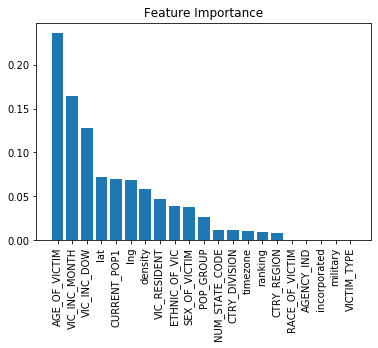

In [38]:
# Find most important features in Random Forest model
import matplotlib.pyplot as plt

# Calculate feature importances
importances = forest.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()


In [39]:
# Re-run random forest, limiting to important features 

# Drop features w/ little importance
data_model_X.drop(['RACE_OF_VICTIM', 'AGENCY_IND', 'military', 'incorporated', 'VICTIM_TYPE'],
                  axis=1, inplace = True)

# Split the data into training and validation datasets
# Save 30% for validation
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=7)


In [49]:
# Rerun random forest classifer object
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=-1, max_depth=25, bootstrap=False)
#randomforest = RandomForestClassifier(random_state=0, n_estimators=284, n_jobs=-1, max_depth=17, bootstrap=False)

# Train model
forest = randomforest.fit(X_train, y_train)

# Predict values
y_pred_forest = forest.predict(X_val)

# Create classification report
print(classification_report(y_val, y_pred_tree))

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          91       0.16      0.21      0.18       262
          92       0.09      0.09      0.09        11
          93       0.08      0.10      0.09        10
         100       0.19      0.29      0.23      1322
         111       0.13      0.14      0.13      1843
         112       0.41      0.42      0.41       505
         113       0.14      0.15      0.15       133
         114       0.40      0.37      0.38      2104
         120       0.41      0.50      0.45      7490
         131       0.41      0.51      0.45     23283
         132       0.45      0.48      0.46     59003
         133       0.39      0.41      0.40     18873
         200       0.44      0.54      0.48       965
         210       0.10      0.10      0.10       153
         220       0.37      0.40      0.38     32217
         231       0.13      0.12      0.12       433
         232       0.11      0.10      0.10       372
         233       0.19    